### Research Process 


#### Init Libraries

In [1]:
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


#### Load Dataset and split into Features and Label

In [2]:
#load data
df=pd.read_csv("breast-cancer-wisconsin-data/data.csv")
#drop irelevent columns for the classification
df = df.drop(columns=['Unnamed: 32', 'id'])
# rearange the data for X - featuers and Y leabels 
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

#### Encode Labels

In [3]:
le = LabelEncoder()
y = le.fit_transform(y)

#### The mapping of the labels

In [4]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'B': 0, 'M': 1}


#### Splitting the data into Train, Test and Valid datasets

In [5]:
#split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### Scale the data

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

#### Handling the imbalance between the classes

In [7]:
#handling imbalance data 
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
#the class weight is done only on the train data to impact the learning process and to evaluete beter the model proformence
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.7878787878787878, 1: 1.368421052631579}

as predicted the minorty class 'M'=1 gets higher weight of 1.368

### Neural Networks

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


def model_result(model):
    print('================================================================================')
    print(f'Evaluation Report for Model: {model.name}')

    # accuracy
    result = model.evaluate(X_test, y_test, verbose=0)        
    print(f'Loss Value: {result[0]:.3f}, Accuracy: {result[1]*100:.3f}%')

    # confusion matrix
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.round(y_prob).astype(int)    
    cm_test = confusion_matrix(y_test, y_pred)    
    #sns.heatmap(cm_test,annot=True)
    cm_disp = ConfusionMatrixDisplay(cm_test, display_labels=le.classes_)
    cm_disp.plot()
    plt.show()

    # classification report
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print(report)

    print('Model Summary:')
    print(model.summary())
    print('================================================================================')

In [9]:
def model_history(history):
    plt.figure(figsize=(15,6))

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.plot(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], 'r*', label='Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_loss'][val_loss_min_pos]:.3f})', va='bottom')
    plt.legend()

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], 'r*', label='Validation Accuracy @ Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_accuracy'][val_loss_min_pos]:.3f})', va='bottom')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.show()    

##### Init Libraries

In [10]:
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.regularizers import l1, l2
#from keras.layers import Dropout, Flatten, BatchNormalization
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics
from keras import callbacks
from keras import utils


##### Build the model

#### SLP

##### SLP Baseline

In [11]:
utils.set_random_seed(0)
MODEL_NAME = 'SLP'

model = models.Sequential(name=f'{MODEL_NAME}')
model.add(layers.Dense(1, activation='sigmoid', input_shape=(30,)))

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
checkpoint_filepath = f'model_checkpoints/{MODEL_NAME}_checkpoint.model.keras'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=50, epochs=600, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=[model_checkpoint_callback, reduce_lr])

model = models.load_model(checkpoint_filepath)

Epoch 1/600


d:\Yakir\Development\Python\DL\Breast-Cancer-Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9056 - loss: 0.3548 - val_accuracy: 0.9011 - val_loss: 0.3663 - learning_rate: 3.0000e-04
Epoch 2/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9152 - loss: 0.3473 - val_accuracy: 0.9121 - val_loss: 0.3602 - learning_rate: 3.0000e-04
Epoch 3/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9131 - loss: 0.3402 - val_accuracy: 0.9121 - val_loss: 0.3543 - learning_rate: 3.0000e-04
Epoch 4/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9149 - loss: 0.3334 - val_accuracy: 0.9121 - val_loss: 0.3487 - learning_rate: 3.0000e-04
Epoch 5/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9149 - loss: 0.3269 - val_accuracy: 0.9231 - val_loss: 0.3433 - learning_rate: 3.0000e-04
Epoch 6/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9226 - loss: 0.3207 - val_accuracy: 0.9231 - val_loss: 0.3382 - learning_rate: 3.0000e-04
Epoch 7/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9274 - loss: 0.3148 - val_accu

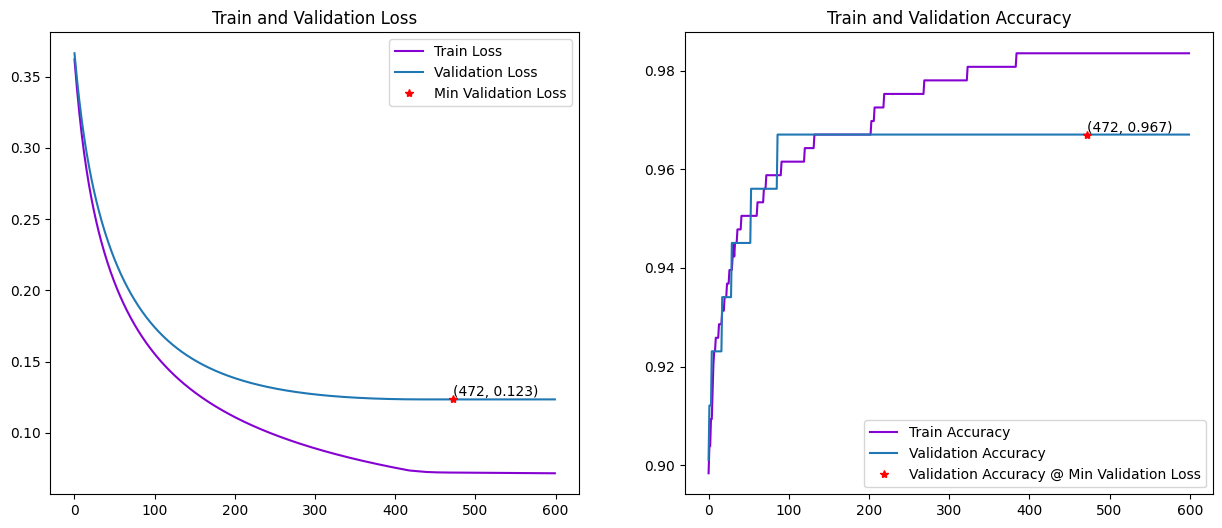

In [12]:
model_history(history)

Evaluation Report for Model: SLP
Loss Value: 0.067, Accuracy: 97.368%


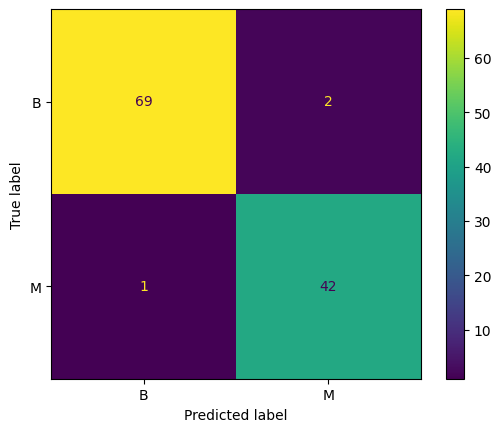

              precision    recall  f1-score   support

           B       0.99      0.97      0.98        71
           M       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Model Summary:


Model: "SLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95 (384.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64 (260.00 B)

None


In [13]:
model_result(model)

##### SLP with Dropout 0.2

In [14]:
utils.set_random_seed(0)
MODEL_NAME = 'SLP_Dropout_0.2'

model = models.Sequential(name=f'{MODEL_NAME}')

model.add(layers.Dropout(rate=0.2, input_shape=(30,)))

model.add(layers.Dense(1, activation='sigmoid'))

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
checkpoint_filepath = f'model_checkpoints/{MODEL_NAME}_checkpoint.model.keras'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=50, epochs=1000, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=[model_checkpoint_callback, reduce_lr])

model = models.load_model(checkpoint_filepath)

Epoch 1/1000


d:\Yakir\Development\Python\DL\Breast-Cancer-Prediction\.venv\Lib\site-packages\keras\src\layers\regularization\dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1620 - loss: 1.5735 - val_accuracy: 0.1319 - val_loss: 1.3601 - learning_rate: 3.0000e-04
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1691 - loss: 1.4910 - val_accuracy: 0.1319 - val_loss: 1.3390 - learning_rate: 3.0000e-04
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1805 - loss: 1.4413 - val_accuracy: 0.1319 - val_loss: 1.3181 - learning_rate: 3.0000e-04
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1603 - loss: 1.4657 - val_accuracy: 0.1319 - val_loss: 1.2975 - learning_rate: 3.0000e-04
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1695 - loss: 1.4347 - val_accuracy: 0.1319 - val_loss: 1.2772 - learning_rate: 3.0000e-04
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2085 - loss: 1.4016 - val_accuracy: 0.1319 - val_loss: 1.2572 - learning_rate: 3.0000e-04
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2020 - loss: 1.3791 - va

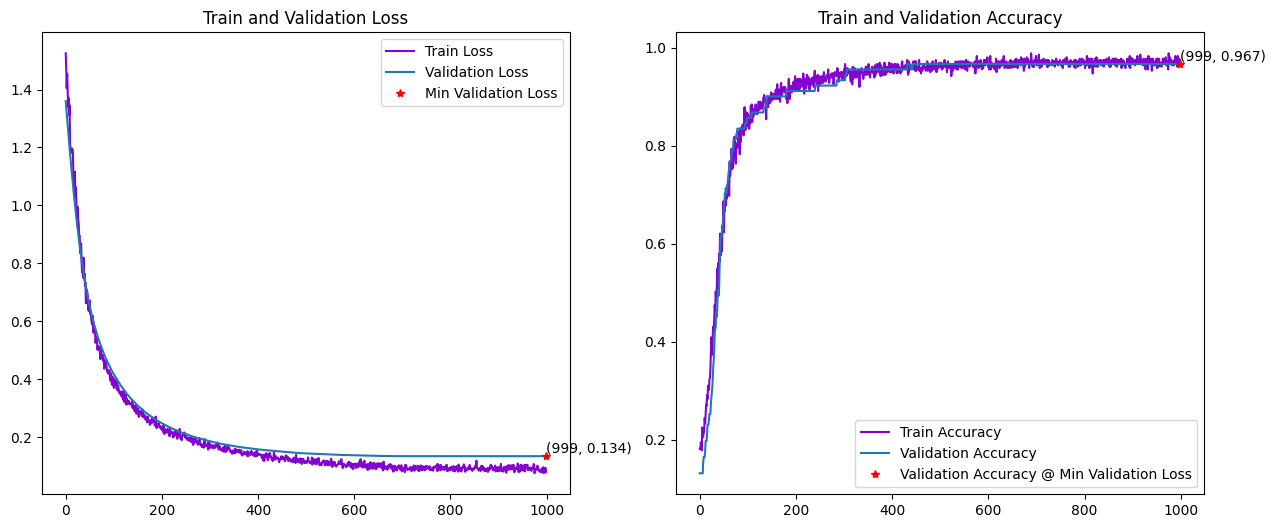

In [15]:
model_history(history)

Evaluation Report for Model: SLP_Dropout_0.2
Loss Value: 0.072, Accuracy: 97.368%


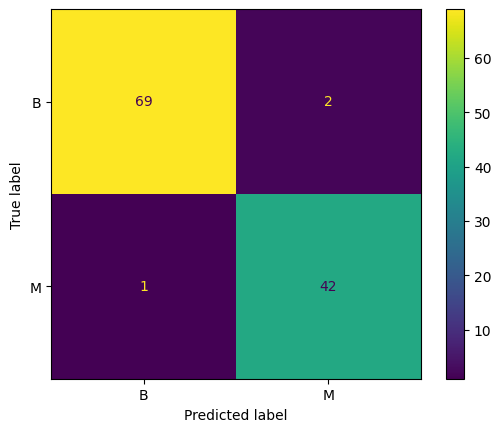

              precision    recall  f1-score   support

           B       0.99      0.97      0.98        71
           M       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Model Summary:


Model: "SLP_Dropout_0.2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95 (384.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64 (260.00 B)

None


In [16]:
model_result(model)

#### MLP

##### MLP Baseline

In [17]:
utils.set_random_seed(0)
MODEL_NAME = 'MLP'

model = models.Sequential(name=f'{MODEL_NAME}')
model.add(layers.Dense(1, activation='relu', input_shape=(30,)))
model.add(layers.Dense(1, activation='sigmoid'))

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
checkpoint_filepath = f'model_checkpoints/{MODEL_NAME}_checkpoint.model.keras'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=50, epochs=2000, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=[model_checkpoint_callback, reduce_lr])

model = models.load_model(checkpoint_filepath)

Epoch 1/2000


d:\Yakir\Development\Python\DL\Breast-Cancer-Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2613 - loss: 0.9913 - val_accuracy: 0.0989 - val_loss: 0.8943 - learning_rate: 3.0000e-04
Epoch 2/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0926 - loss: 0.9793 - val_accuracy: 0.0989 - val_loss: 0.8869 - learning_rate: 3.0000e-04
Epoch 3/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0932 - loss: 0.9680 - val_accuracy: 0.0989 - val_loss: 0.8795 - learning_rate: 3.0000e-04
Epoch 4/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0932 - loss: 0.9570 - val_accuracy: 0.0989 - val_loss: 0.8724 - learning_rate: 3.0000e-04
Epoch 5/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0932 - loss: 0.9462 - val_accuracy: 0.0989 - val_loss: 0.8653 - learning_rate: 3.0000e-04
Epoch 6/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1013 - loss: 0.9357 - val_accuracy: 0.0989 - val_loss: 0.8584 - learning_rate: 3.0000e-04
Epoch 7/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1107 - loss: 0.9258 - va

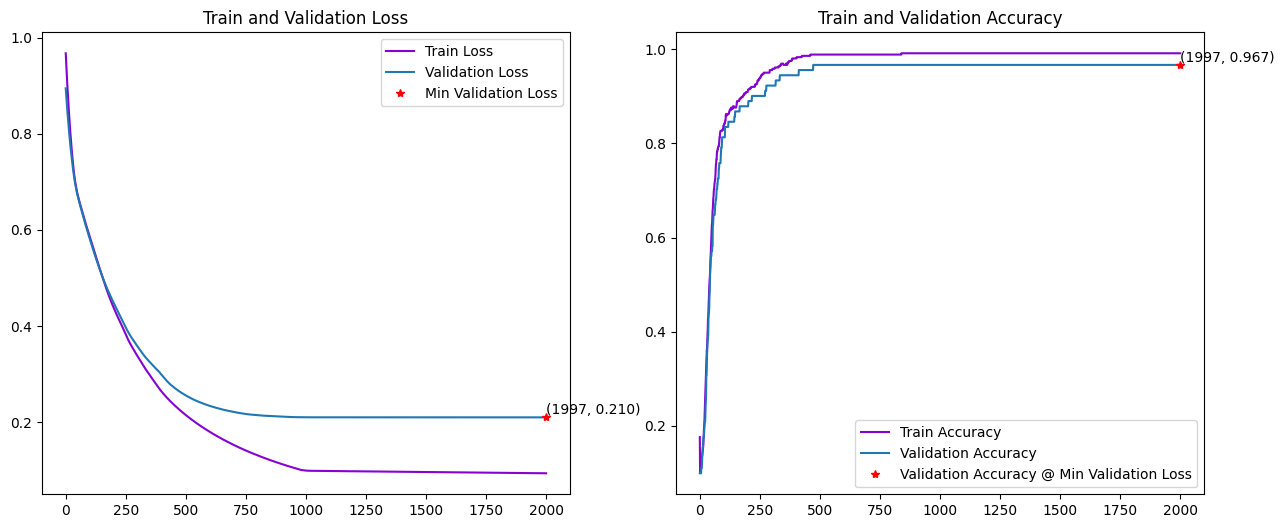

In [18]:
model_history(history)

Evaluation Report for Model: MLP
Loss Value: 0.104, Accuracy: 97.368%


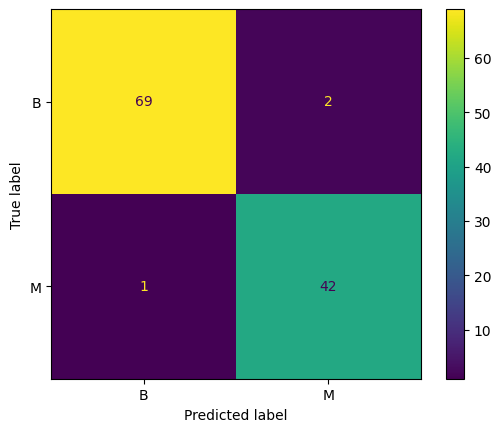

              precision    recall  f1-score   support

           B       0.99      0.97      0.98        71
           M       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Model Summary:


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1)              │            31 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (408.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 68 (276.00 B)

None


In [19]:
model_result(model)

##### MLP [1:30]

In [20]:
utils.set_random_seed(0)
MODEL_NAME = 'MLP'

model = models.Sequential(name=f'{MODEL_NAME}')
model.add(layers.Dense(30, activation='relu', input_shape=(30,)))
model.add(layers.Dense(1, activation='sigmoid'))

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
checkpoint_filepath = f'model_checkpoints/{MODEL_NAME}_checkpoint.model.keras'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=50, epochs=600, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=[model_checkpoint_callback, reduce_lr])

model = models.load_model(checkpoint_filepath)

Epoch 1/600


d:\Yakir\Development\Python\DL\Breast-Cancer-Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6565 - loss: 0.8365 - val_accuracy: 0.6484 - val_loss: 0.6059 - learning_rate: 3.0000e-04
Epoch 2/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6813 - loss: 0.7719 - val_accuracy: 0.6703 - val_loss: 0.5666 - learning_rate: 3.0000e-04
Epoch 3/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7060 - loss: 0.7150 - val_accuracy: 0.7363 - val_loss: 0.5308 - learning_rate: 3.0000e-04
Epoch 4/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7424 - loss: 0.6636 - val_accuracy: 0.7802 - val_loss: 0.4984 - learning_rate: 3.0000e-04
Epoch 5/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7712 - loss: 0.6171 - val_accuracy: 0.7912 - val_loss: 0.4693 - learning_rate: 3.0000e-04
Epoch 6/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7811 - loss: 0.5749 - val_accuracy: 0.8242 - val_loss: 0.4433 - learning_rate: 3.0000e-04
Epoch 7/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8347 - loss: 0.5372 - val_accu

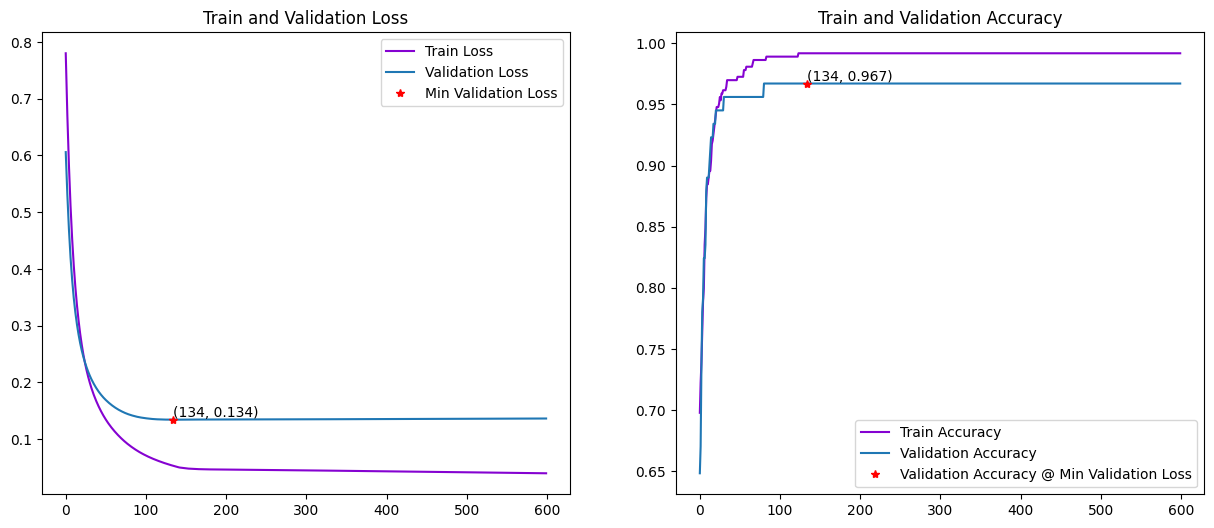

In [21]:
model_history(history)

Evaluation Report for Model: MLP
Loss Value: 0.071, Accuracy: 96.491%


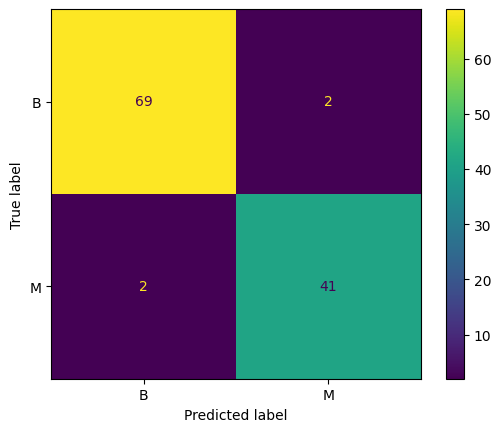

              precision    recall  f1-score   support

           B       0.97      0.97      0.97        71
           M       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

Model Summary:


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,885 (11.27 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,924 (7.52 KB)

None


In [22]:
model_result(model)

##### MLP [1:30, 2:30]

In [23]:
utils.set_random_seed(0)
MODEL_NAME = 'MLP_L1_30_L2_30'

model = models.Sequential(name=f'{MODEL_NAME}')

model.add(layers.Dense(30, activation='relu', input_shape=(30,)))

model.add(layers.Dense(30, activation='relu', input_shape=(30,)))

model.add(layers.Dense(1, activation='sigmoid'))

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
checkpoint_filepath = f'model_checkpoints/{MODEL_NAME}_checkpoint.model.keras'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=50, epochs=600, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=[model_checkpoint_callback, reduce_lr])

model = models.load_model(checkpoint_filepath)

Epoch 1/600


d:\Yakir\Development\Python\DL\Breast-Cancer-Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3671 - loss: 0.7695 - val_accuracy: 0.3956 - val_loss: 0.8150 - learning_rate: 3.0000e-04
Epoch 2/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3817 - loss: 0.7159 - val_accuracy: 0.4176 - val_loss: 0.7631 - learning_rate: 3.0000e-04
Epoch 3/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4015 - loss: 0.6685 - val_accuracy: 0.4835 - val_loss: 0.7153 - learning_rate: 3.0000e-04
Epoch 4/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4595 - loss: 0.6254 - val_accuracy: 0.5385 - val_loss: 0.6711 - learning_rate: 3.0000e-04
Epoch 5/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5778 - loss: 0.5863 - val_accuracy: 0.6264 - val_loss: 0.6309 - learning_rate: 3.0000e-04
Epoch 6/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7398 - loss: 0.5507 - val_accuracy: 0.7363 - val_loss: 0.5941 - learning_rate: 3.0000e-04
Epoch 7/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8088 - loss: 0.5172 - val_accu

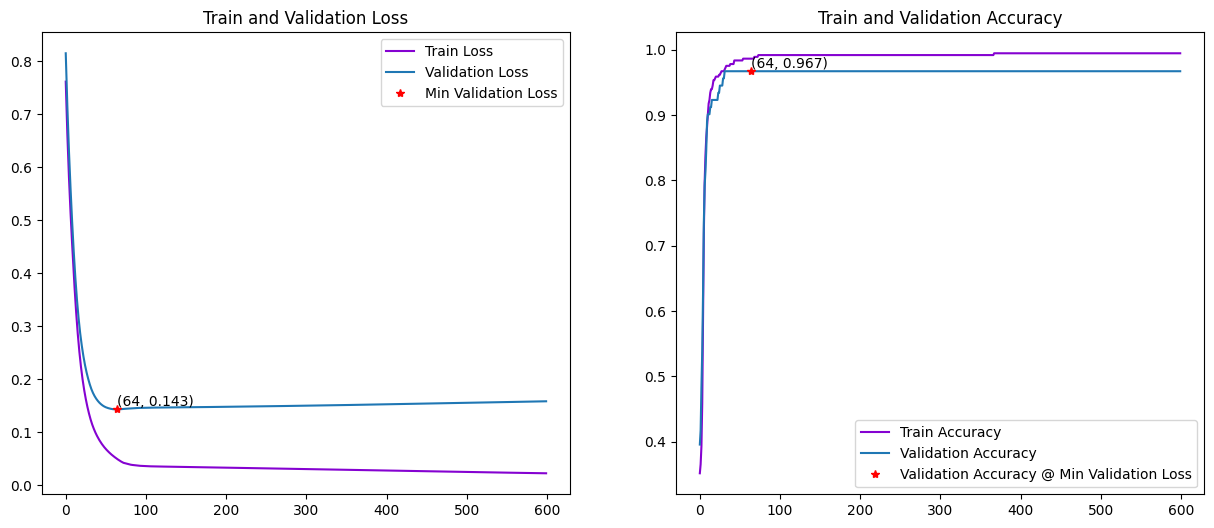

In [24]:
model_history(history)

Evaluation Report for Model: MLP_L1_30_L2_30
Loss Value: 0.088, Accuracy: 95.614%


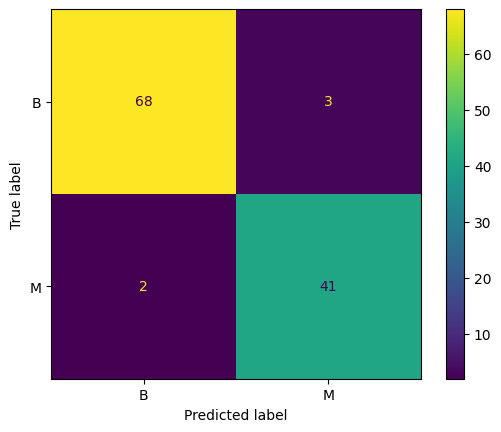

              precision    recall  f1-score   support

           B       0.97      0.96      0.96        71
           M       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

Model Summary:


Model: "MLP_L1_30_L2_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,675 (22.17 KB)

 Trainable params: 1,891 (7.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,784 (14.79 KB)

None


In [25]:
model_result(model)

##### MLP [1:30] Dropout 0.5

In [26]:
utils.set_random_seed(0)
MODEL_NAME = 'MLP_Dropout_0.5'

model = models.Sequential(name=f'{MODEL_NAME}')

model.add(layers.Dense(30, activation='relu', input_shape=(30,)))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(1, activation='sigmoid'))

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
checkpoint_filepath = f'model_checkpoints/{MODEL_NAME}_checkpoint.model.keras'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=50, epochs=1000, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=[model_checkpoint_callback, reduce_lr])

model = models.load_model(checkpoint_filepath)

Epoch 1/1000


d:\Yakir\Development\Python\DL\Breast-Cancer-Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5152 - loss: 0.7940 - val_accuracy: 0.4945 - val_loss: 0.7644 - learning_rate: 3.0000e-04
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5493 - loss: 0.7106 - val_accuracy: 0.5385 - val_loss: 0.7217 - learning_rate: 3.0000e-04
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5636 - loss: 0.7062 - val_accuracy: 0.5714 - val_loss: 0.6818 - learning_rate: 3.0000e-04
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6137 - loss: 0.6185 - val_accuracy: 0.6154 - val_loss: 0.6456 - learning_rate: 3.0000e-04
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6628 - loss: 0.6130 - val_accuracy: 0.6374 - val_loss: 0.6126 - learning_rate: 3.0000e-04
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6372 - loss: 0.6026 - val_accuracy: 0.6703 - val_loss: 0.5815 - learning_rate: 3.0000e-04
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6891 - loss: 0.5754 - va

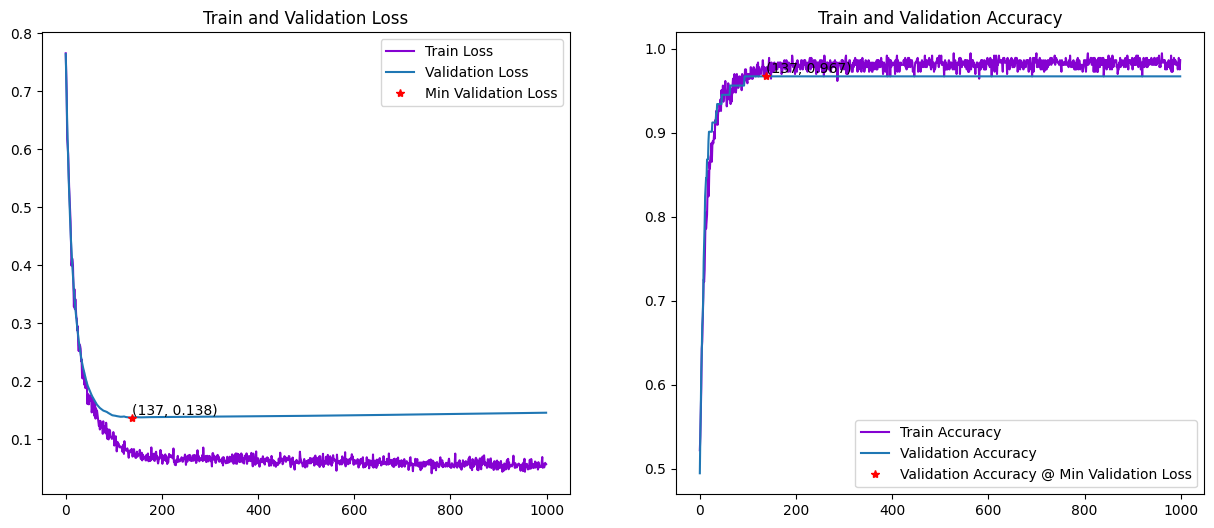

In [27]:
model_history(history)

Evaluation Report for Model: MLP_Dropout_0.5
Loss Value: 0.073, Accuracy: 96.491%


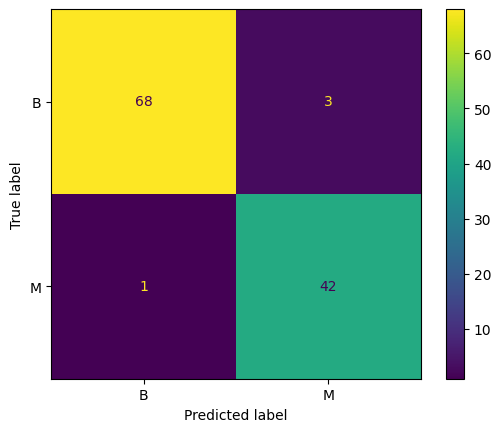

              precision    recall  f1-score   support

           B       0.99      0.96      0.97        71
           M       0.93      0.98      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

Model Summary:


Model: "MLP_Dropout_0.5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,885 (11.27 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,924 (7.52 KB)

None


In [28]:
model_result(model)

##### MLP [1:30 Dropout 0.5, 2:30 Dropout 0.5,] 

In [29]:
utils.set_random_seed(0)
MODEL_NAME = 'MLP_Dropout_0.5'

model = models.Sequential(name=f'{MODEL_NAME}')

model.add(layers.Dense(30, activation='relu', input_shape=(30,)))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(1, activation='sigmoid'))

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
checkpoint_filepath = f'model_checkpoints/{MODEL_NAME}_checkpoint.model.keras'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=50, epochs=1000, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=[model_checkpoint_callback, reduce_lr])

model = models.load_model(checkpoint_filepath)

Epoch 1/1000


d:\Yakir\Development\Python\DL\Breast-Cancer-Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3469 - loss: 0.9823 - val_accuracy: 0.4176 - val_loss: 0.8437 - learning_rate: 3.0000e-04
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3892 - loss: 0.9365 - val_accuracy: 0.4286 - val_loss: 0.7992 - learning_rate: 3.0000e-04
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3958 - loss: 0.9101 - val_accuracy: 0.4505 - val_loss: 0.7601 - learning_rate: 3.0000e-04
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4443 - loss: 0.8242 - val_accuracy: 0.4835 - val_loss: 0.7250 - learning_rate: 3.0000e-04
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4313 - loss: 0.8328 - val_accuracy: 0.4945 - val_loss: 0.6932 - learning_rate: 3.0000e-04
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5070 - loss: 0.8118 - val_accuracy: 0.5604 - val_loss: 0.6634 - learning_rate: 3.0000e-04
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5580 - loss: 0.7048 - va

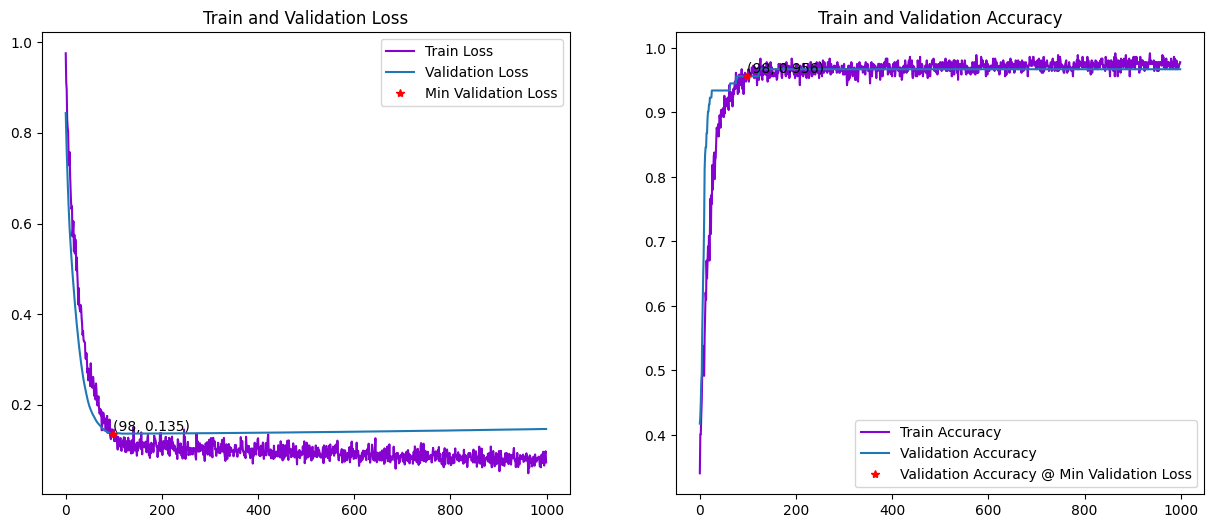

In [30]:
model_history(history)

Evaluation Report for Model: MLP_Dropout_0.5
Loss Value: 0.069, Accuracy: 96.491%


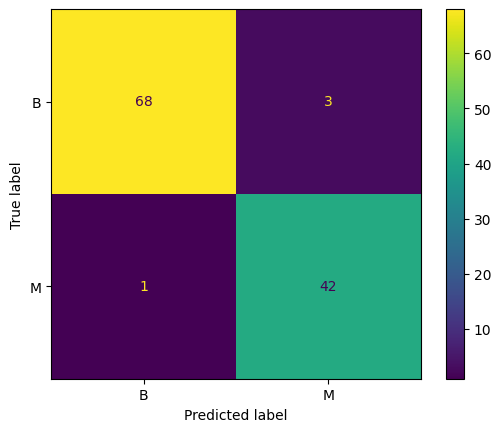

              precision    recall  f1-score   support

           B       0.99      0.96      0.97        71
           M       0.93      0.98      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

Model Summary:


Model: "MLP_Dropout_0.5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,675 (22.17 KB)

 Trainable params: 1,891 (7.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,784 (14.79 KB)

None


In [31]:
model_result(model)

##### MLP [1:15 Dropout 0.5, 2:15 Dropout 0.5,] 

In [32]:
utils.set_random_seed(0)
MODEL_NAME = 'MLP_L1_15_L2_15_Dropout_0.5'

model = models.Sequential(name=f'{MODEL_NAME}')

model.add(layers.Dense(15, activation='relu', input_shape=(30,)))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(1, activation='sigmoid'))

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
checkpoint_filepath = f'model_checkpoints/{MODEL_NAME}_checkpoint.model.keras'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=50, epochs=1000, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=[model_checkpoint_callback, reduce_lr])

model = models.load_model(checkpoint_filepath)

Epoch 1/1000


d:\Yakir\Development\Python\DL\Breast-Cancer-Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5471 - loss: 0.7571 - val_accuracy: 0.7143 - val_loss: 0.6097 - learning_rate: 0.0010
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5635 - loss: 0.7561 - val_accuracy: 0.8022 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6492 - loss: 0.6322 - val_accuracy: 0.8462 - val_loss: 0.5375 - learning_rate: 0.0010
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6562 - loss: 0.6332 - val_accuracy: 0.8791 - val_loss: 0.5044 - learning_rate: 0.0010
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6740 - loss: 0.5798 - val_accuracy: 0.8901 - val_loss: 0.4736 - learning_rate: 0.0010
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7196 - loss: 0.5577 - val_accuracy: 0.8901 - val_loss: 0.4441 - learning_rate: 0.0010
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7805 - loss: 0.5097 - val_accuracy: 0.9121 - val

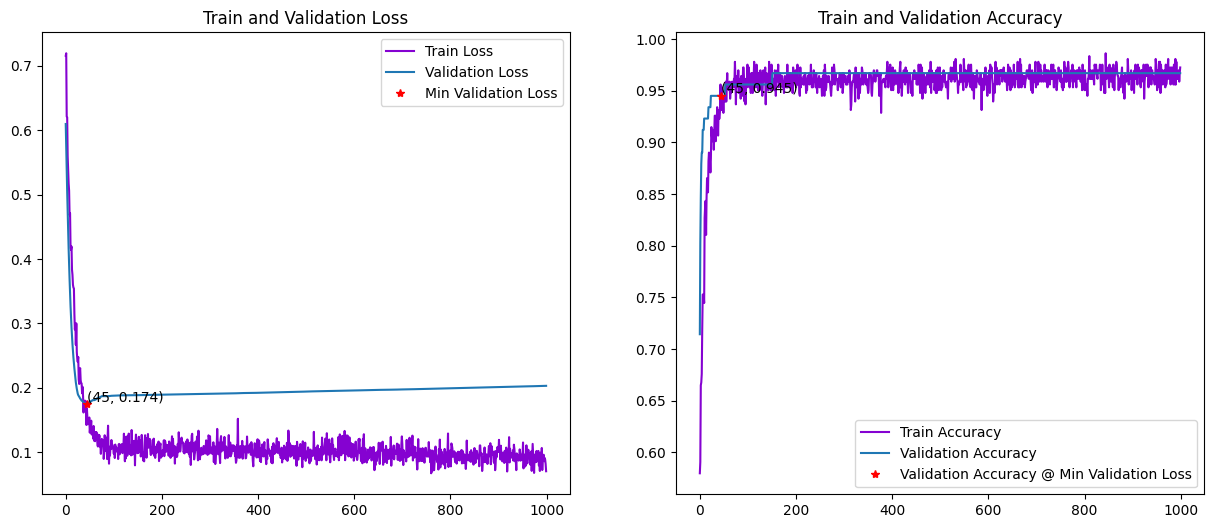

In [33]:
model_history(history)

Evaluation Report for Model: MLP_L1_15_L2_15_Dropout_0.5
Loss Value: 0.070, Accuracy: 96.491%


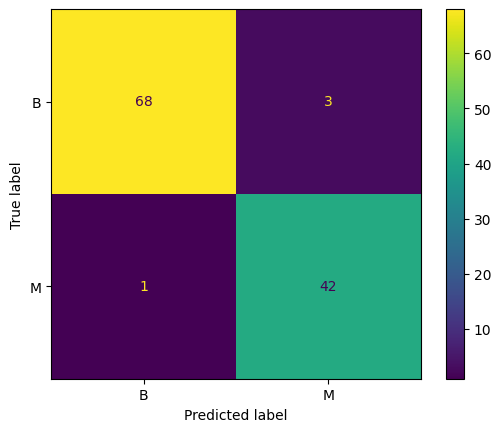

              precision    recall  f1-score   support

           B       0.99      0.96      0.97        71
           M       0.93      0.98      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

Model Summary:


Model: "MLP_L1_15_L2_15_Dropout_0.5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,165 (8.46 KB)

 Trainable params: 721 (2.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,444 (5.64 KB)

None


In [34]:
model_result(model)

##### MLP [1:15 tanh Dropout 0.5, 2:15 tanh Dropout 0.5,] 

In [35]:
utils.set_random_seed(0)
MODEL_NAME = 'MLP_L1_15_tanh_L2_15_tanh_Dropout_0.5'

model = models.Sequential(name=f'{MODEL_NAME}')

model.add(layers.Dense(15, activation='tanh', input_shape=(30,)))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(15, activation='tanh'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(1, activation='sigmoid'))

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
checkpoint_filepath = f'model_checkpoints/{MODEL_NAME}_checkpoint.model.keras'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=50, epochs=1000, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=[model_checkpoint_callback, reduce_lr])

model = models.load_model(checkpoint_filepath)

Epoch 1/1000


d:\Yakir\Development\Python\DL\Breast-Cancer-Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5885 - loss: 0.6855 - val_accuracy: 0.8242 - val_loss: 0.5622 - learning_rate: 0.0010
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6235 - loss: 0.6359 - val_accuracy: 0.8462 - val_loss: 0.4975 - learning_rate: 0.0010
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7010 - loss: 0.5363 - val_accuracy: 0.8571 - val_loss: 0.4473 - learning_rate: 0.0010
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7463 - loss: 0.5329 - val_accuracy: 0.8681 - val_loss: 0.4083 - learning_rate: 0.0010
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7821 - loss: 0.4394 - val_accuracy: 0.8681 - val_loss: 0.3758 - learning_rate: 0.0010
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8378 - loss: 0.4197 - val_accuracy: 0.9011 - val_loss: 0.3479 - learning_rate: 0.0010
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8849 - loss: 0.3560 - val_accuracy: 0.9121 - val

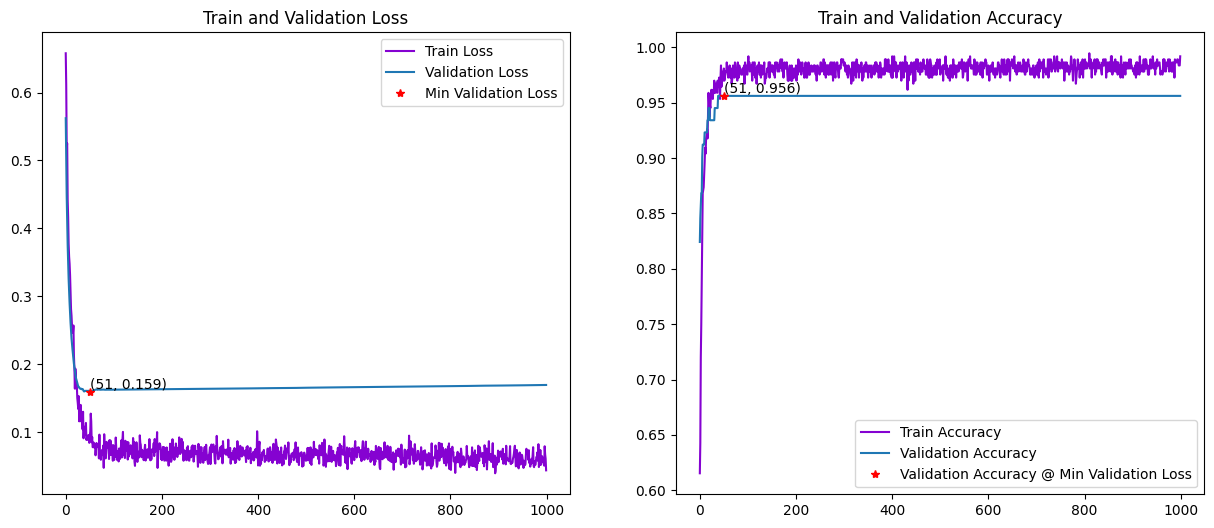

In [36]:
model_history(history)

Evaluation Report for Model: MLP_L1_15_tanh_L2_15_tanh_Dropout_0.5
Loss Value: 0.068, Accuracy: 97.368%


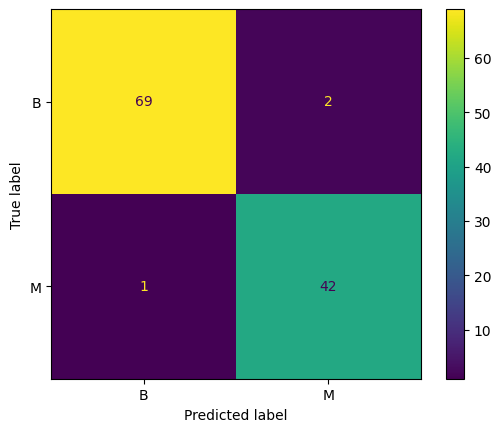

              precision    recall  f1-score   support

           B       0.99      0.97      0.98        71
           M       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Model Summary:


Model: "MLP_L1_15_tanh_L2_15_tanh_Dropout_0.5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,165 (8.46 KB)

 Trainable params: 721 (2.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,444 (5.64 KB)

None


In [37]:
model_result(model)